#github:@RayenR1 | linkedin :Rayen Jlassi

[2025/03/30 23:40:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

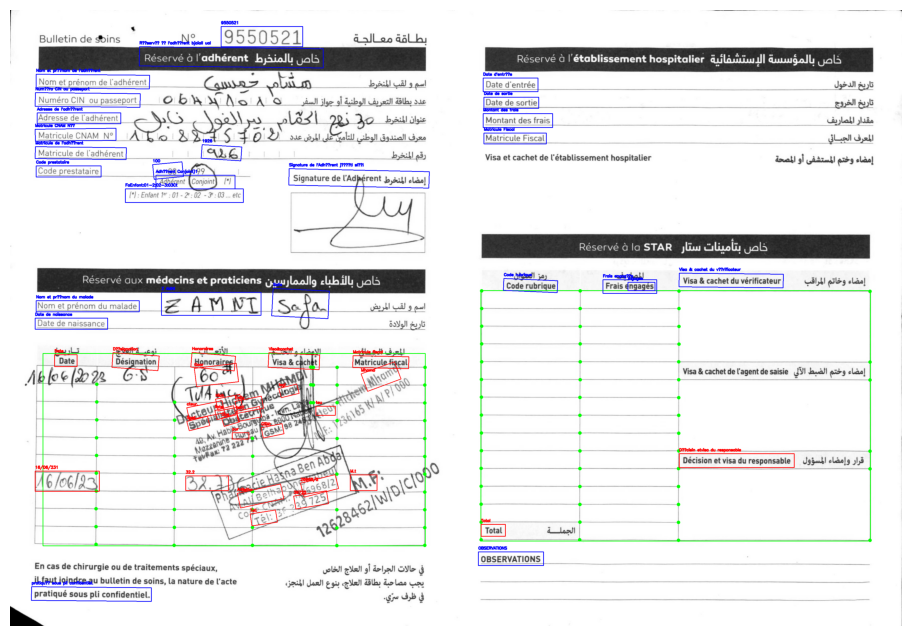

In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json

# -------- CONFIGURATION ----------
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

# -------- FONCTIONS DE DÉTECTION DE TABLEAUX --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    """Applique un seuillage adaptatif à l'image."""
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    """Trouve les lignes horizontales ou verticales."""
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Direction doit être 'vertical' ou 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    """Trouve les contours des tableaux."""
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    """Trouve les intersections dans les tableaux."""
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FONCTIONS D'EXTRACTION DES CHAMPS --------
def contains_arabic(text):
    return bool(re.search("[\\u0600-\\u06FF]", text))

def is_likely_handwritten(text, box, image):
    width = box[2][0] - box[0][0]
    height = box[2][1] - box[0][1]
    aspect_ratio = width / height if height > 0 else 0
    if aspect_ratio < 0.5 or aspect_ratio > 10 or len(text) < 3:
        return True
    return False

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    """Prétraite l'image selon le mode spécifié."""
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent (IoU)."""
    x1, y1 = box1[0][0], box1[0][1]
    x2, y2 = box1[2][0], box1[2][1]
    x1_p, y1_p = box2[0][0], box2[0][1]
    x2_p, y2_p = box2[2][0], box2[2][1]

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    """Extrait le texte et la disposition avec OCR séquentiel."""
    modes = ["grayscale", "rgb", "binary", "contrast"]
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Application de l'OCR avec le mode {mode}")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if is_likely_handwritten(text, box, preprocessed_img):
                    continue
                if len(text) < 2:
                    continue

                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                if not overlaps:
                    extracted_data.append({"text": text, "box": box})

    print(f"[INFO] Nombre total de boîtes détectées : {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    """Filtre les noms de champs probables."""
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

def is_inside_table(box, table_bbox):
    """Vérifie si une boîte est dans un tableau."""
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for key in table_bbox.keys():
        x1, y2, x2, y1 = key
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_image(image_path, table_bbox, extracted_data, output_path="combined_result.jpg"):
    """Annote l'image avec les tableaux et les champs."""
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Impossible de charger l'image pour l'annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    for item in extracted_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)

        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=2, lineType=cv2.LINE_AA)

    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# -------- FONCTIONS DE SAUVEGARDE --------
def save_boxes_to_file(extracted_data, filename="detected_boxes.json"):
    """Sauvegarde les boîtes détectées dans un fichier JSON."""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(extracted_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Boîtes détectées sauvegardées dans {filename}")

def main(doc_path):
    # Étape 1 : Détection des tableaux
    process_background = False
    threshold_blocksize = 15
    threshold_constant = -2
    image, threshold = adaptive_threshold(
        doc_path,
        process_background=process_background,
        blocksize=threshold_blocksize,
        c=threshold_constant,
    )

    regions = None
    iterations = 0
    line_scale = 15
    vertical_mask, vertical_segments = find_lines(
        threshold,
        regions=regions,
        direction="vertical",
        line_scale=line_scale,
        iterations=iterations,
    )
    horizontal_mask, horizontal_segments = find_lines(
        threshold,
        regions=regions,
        direction="horizontal",
        line_scale=line_scale,
        iterations=iterations,
    )

    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Filtrer les tableaux trop grands
    image_height, image_width = image.shape[:2]
    image_area = image_height * image_width
    threshold_area_ratio = 0.9  # 90% de la taille de l'image
    filtered_table_bbox = {}
    for tab, joints in table_bbox.items():
        x1, y2, x2, y1 = tab
        table_width = x2 - x1
        table_height = y2 - y1
        table_area = table_width * table_height
        if table_area / image_area < threshold_area_ratio:
            filtered_table_bbox[tab] = joints
        else:
            print(f"[INFO] Suppression du tableau {tab} car il couvre {table_area / image_area * 100:.2f}% de l'image.")
    table_bbox = filtered_table_bbox

    # Étape 2 : Extraction des champs avec OCR
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    filtered_data = filter_field_names(extracted_data)

    # Étape 3 : Sauvegarder les boîtes détectées initialement
    save_boxes_to_file(filtered_data, "initial_detected_boxes.json")

    # Étape 4 : Pas de filtrage supplémentaire basé sur les champs communs
    final_filtered_data = filtered_data

    # Étape 5 : Sauvegarder les boîtes filtrées finales
    save_boxes_to_file(final_filtered_data, "final_filtered_boxes.json")

    # Étape 6 : Annoter l'image
    annotate_image(doc_path, table_bbox, final_filtered_data, output_path="combined_result.jpg")

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\image.png"
    main(document_path)